# Monte Carlo Option Pricer for European Stock Options

In this notebook, we explore application of Monte Carlo simulation methods in order to effectively model outcomes for analysis. Monte carlo models can incorporate multiple sources of risk, allowing for significant reduction in uncertainty and improvement in accuracy. I further this point later in the notebook, where I demonstrate how the number of simulations used in the Monte Carlo model affects the accuracy of pricing.

## European Call Options vs American Call Options

A call option gives the holder the right, but not the obligation, to buy an asset at a specified strike price on the option's expiration date. The reason I specifically state 'European', is to draw attention to buying the asset ON the option's expiration date unlike American options, which can be exercised anytime in BETWEEN the trade and expiration date.

The value of a European call option is mainly influenced by factors including: the stock price, strike price, volatility, time to expiration, and the risk-free interest rate (which we set to be 2%).

## Black-Scholes Model

To calculate an option’s theoretical value we use the Black-Scholes model. We feed in inputs and it returns a theoretical value for the option whilst also implementing a risk-less hedge. In order to use this model for pricing we needfive characteristics of the option and its underlying contract:
1. The option’s exercise price
2. The current price of the underlying contract
3. The time remaining until expiration date 
4. The applicable interest rate over the life of the option
5. The volatility of the underlying contract

The Black-Scholes model uses **geometric brownian motion (GBM)** to model the unpredictable movements of stock prices over time, expressed as:
$$ dS_t = \mu S_t dt + \sigma S_t dW_t $$
where:
- **$S_t$**: Represents the stock price at time $t$.

- **$\mu$**: The drift coefficient (expected return)

- **$\sigma$**: The volatility (standard deviation of returns).

- **$dW_t$**: Represents the increment of Brownian motion over a small time interval $dt$. This component introduces randomness into the model, accounting for the unpredictable fluctuations in the stock price.


## Implementation

The option price is estimated by the Monte Carlo function, simulating multiple possible future paths for the underlying asset's price using GBM, calculating the payoff for each path, and then averaging these payoffs. The payoff for a European call option is given by:
$$
    \text{Payoff} = \max(S_T - K, 0)
$$
where $S_T$ is the simulated stock price at maturity $T$, and $K$ is the strike price.

In this model we calculate the option price ($C$) using the formula:
$$
C = \text{Intrinsic Value} + \text{Time Value}
$$

$$
C = \max(S_0 - K, 0) + S_T
$$

Where:
$$
\begin{aligned}
S_0 &= \text{Current stock price} \\
S_T &= \text{Time Value}
\end{aligned}
$$

To perform a Monte Carlo simulation for option pricing, the GBM model requires us to estimate certain parameters based on historical stock data. These parameters include the annualised mean return ($\mu$), the annualised standard deviation ($\sigma$) and the latest stock price ($S_0$). These mean and standard deviation values are taken off the logarithmic returns from adjusted closing prices from the beginning of 2018 to today.

Logarithmic returns are preferred over simple returns for financial modeling because they are time additive, meaning the total return over multiple periods can be calculated by summing the individual period returns.

The formula for logarithmic returns is:
$$
\text{Log Returns} = \log\left(\frac{P_t}{P_{t-1}}\right)
$$
Where:
- $P_t$ is the adjusted closing price at time $t$ (shown as Adj Close in code)
- $P_{t-1}$is the adjusted closing price at time $(t-1)$ (calculated using .shift(1) of Adj Close values in code)


### GBM simulation
To visually demonstrate our model for stock price paths, we create a function for geometric brownian motion under real-world measure:

$$
S_t = S_0 \exp \left( \left( \mu - \frac{\sigma^2}{2} \right) t + \sigma W_t \right)
$$

Where:
- $S_t$ is the stock price at time \( t \).
- $S_0$ is the initial stock price.
- $\mu$ is the drift coefficient (expected return).
- $\sigma$ is the volatility (standard deviation of returns).
- $W_t$ represents standard Brownian motion

However for actual option pricing using Monte Carlo simulation, the stock price at expiration $S_T$ is simulated using the GBM model under the risk-neutral measure:

$$
S_T = S_0 \exp \left( \left( r - \frac{\sigma^2}{2} \right) T + \sigma \sqrt{T} \cdot Z \right)
$$

Where $Z$ is a random variable drawn from a standard normal distribution $N(0,1)$.

- This involves using the risk-free rate $r$ instead of the drift $\mu$ as, in a risk-neutral world, all assets are expected to grow at the risk-free rate when discounted, ensuring no-arbitrage pricing. 
 
This formula is then simulated a given number of times in the Monte Carlo function to then calculate the expected discounted payoff value for all calculated stock prices (which is then set as our option price).

It does this using the equation:
$$
\text{Discounted Payoff} = \exp(-r \cdot T) \times \text{Payoff}
$$

where $r$ is once again risk-free rate.

[*********************100%%**********************]  1 of 1 completed
Current stock price: 214.2899932861328
Estimated European Call Option Price: 28.90


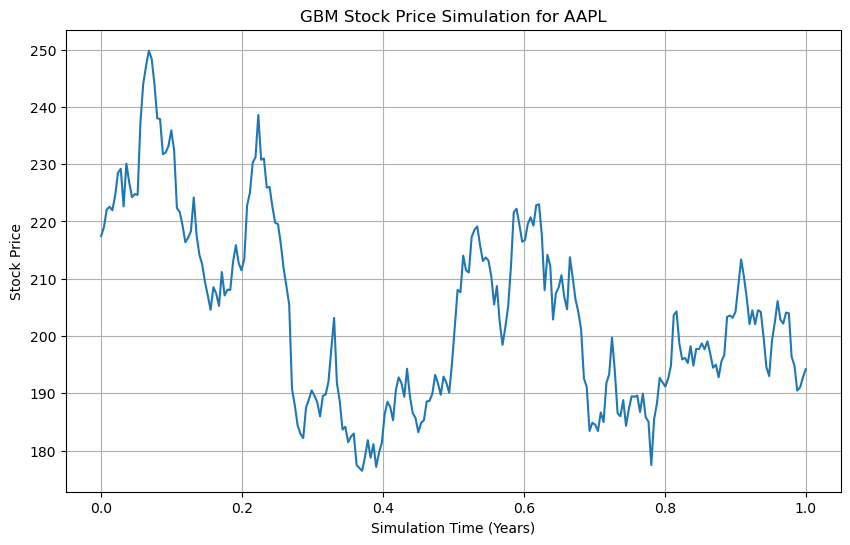

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
import datetime as dt

# Fetch historical stock dataframe of chosen stock using yfinance
ticker = 'AAPL' #Ticker of chosen stock
start_date = dt.datetime(2018, 1, 1) #Start date chosen for GBM analysis
end_date = dt.datetime.today() #End date for GBM analysis set to today
df = yf.download(ticker, start=start_date, end=end_date)

# Calculate the logarithmic returns and statistics
df['Log Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1)) #Setting Logarthimic returns column with the logarithm of P_t / P_t-1 values
mu = df['Log Returns'].mean() * 252  # Annualising the mean
sigma = df['Log Returns'].std() * np.sqrt(252)  # Annualising the standard deviation
S0 = df['Adj Close'][-1]  # Latest stock price from dataframe

print(f"Current stock price: {S0}")

T = 1  #Time in years used for simulation
r = 0.02  # Risk-free rate
num_simulations = 10000  #Number of simulations for the Monte Carlo
time_step = 1 / 252  #Taking into account 252 trading days per year

K = S0 #Strike price set to the today's stock price

#GBM simulation function
def gbm_sim(S0, mu, sigma, T, time_step):
    N = int(T / time_step)
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W)*np.sqrt(time_step)  #Cumulative sum of standard normal variables
    X = (mu - 0.5 * sigma**2) * t + sigma * W #First formula shown above for GBM
    S = S0 * np.exp(X) #Calculating the stock price 
    return S, t

#Simulating GBM path
S, t = gbm_sim(S0, mu, sigma, T, time_step)

#Monte Carlo simulation function
def mc_eurocall(S0, K, T, r, sigma, num_simulations, seed=None):
    """Estimate European call option price using Monte Carlo simulation."""
    if seed:
        np.random.seed(seed) #Set a random seed
    results = []
    final_prices = []
    for i in range(num_simulations):
        S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.randn())#Equation for future stock price at time T.
        payoff = max(S_T - K, 0) #Using formula shown in intro 
        results.append(np.exp(-r * T) * payoff) #Discounted Payoff calculation
        final_prices.append(S_T) #Simulated stock prices at expiration time T 
    return np.mean(results), results, final_prices


#Running the MC sim with a set seed to keep consistency
option_price, payoffs, final_prices = mc_eurocall(S0, K, T, r, sigma, num_simulations, seed=1234)
print("Estimated European Call Option Price: {:.2f}".format(option_price))

#Plotting the GBM simulated stock price path
plt.figure(figsize=(10, 6))
plt.plot(t, S)
plt.title(f'GBM Stock Price Simulation for {ticker}')
plt.ylabel('Stock Price')
plt.xlabel('Simulation Time (Years)')
plt.grid(True)
plt.show()




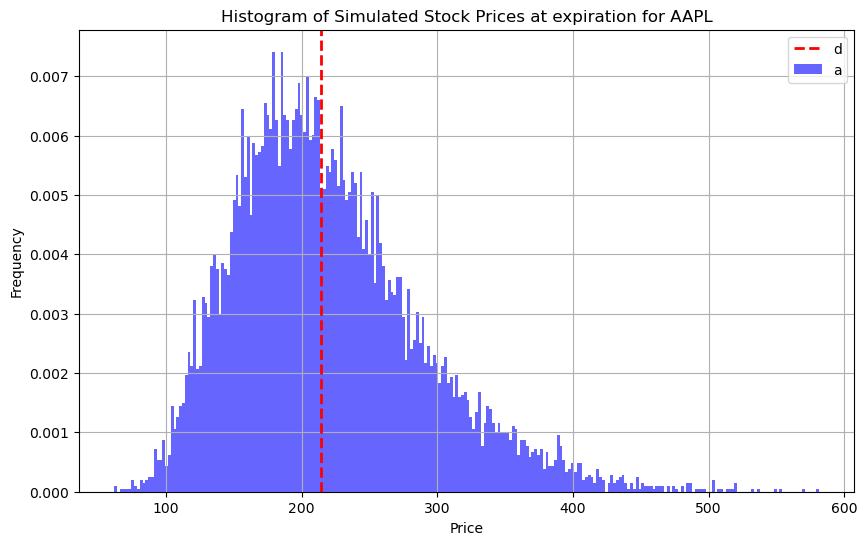

In [108]:
#Histogram of simulated end prices (S_T)
plt.figure(figsize=(10, 6))
plt.hist(final_prices, bins=250, density=True, alpha=0.6, color='b')
plt.axvline(K, color='r', linestyle='dashed', linewidth=2)
plt.title(f'Histogram of Simulated Stock Prices at expiration for {ticker}')
plt.legend('dashed = Strike Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The histogram above shows the strike price (red line) along with the frequency distribution of simulated stock prices $S_T$ generated from the Monte Carlo function.

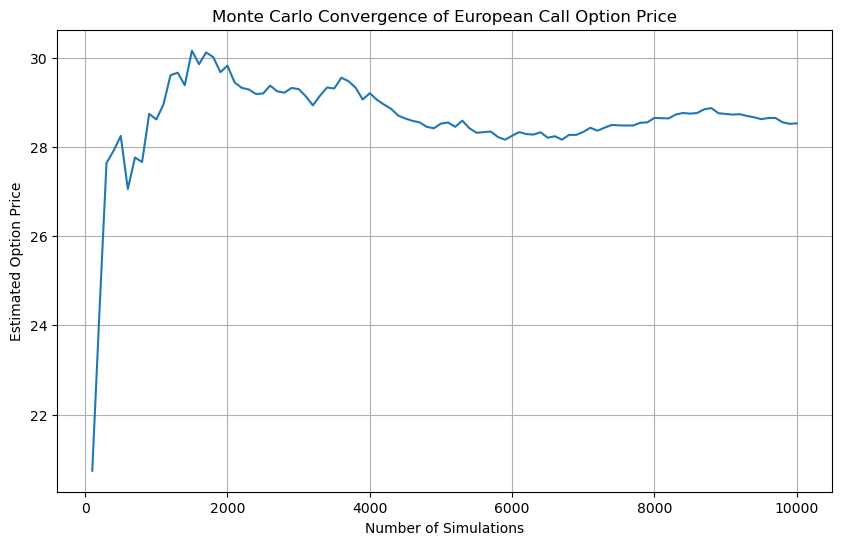

In [107]:
#Convergence with num_simulation demonstration
conv = []
for n in range(100, num_simulations + 1, 100):
    price, _, _ = mc_eurocall(S0, K, T, r, sigma, n, seed=42)
    conv.append(price)

plt.figure(figsize=(10, 6))
plt.plot(range(100, num_simulations + 1, 100), conv)
plt.title('Monte Carlo Convergence of European Call Option Price')
plt.xlabel('Number of Simulations')
plt.ylabel('Estimated Option Price')
plt.grid(True)
plt.show()

As we can see from the plot above, we demonstrate how the number of simulations improve accuracy of the Monte Carlo simulation seen by the significant deviation from option price throughout the lower simulation numbers.